# HAR-Lasso Bipartite Network

Run Lasso regression for each energy stock, extract sparse betas, and visualize the commodity → stock network.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
import networkx as nx
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

DATA_PATH = Path("../US_CRSP_NYSE/Matrix_Format_SubsetUniverse/")
SECTOR_PATH = Path("../US_CRSP_NYSE/Sectors/")

## 1. Load & Prepare Data

Same as notebook 02 — load CRSP returns and commodity HAR features.

In [2]:
# Load CRSP energy stock returns
sectors = pd.read_csv(SECTOR_PATH / "Sectors_SP500_YahooNWikipedia.csv")
energy_tickers = sectors.loc[sectors['Sector_Wikipedia'] == 'Energy', 'Ticker'].tolist()

raw_ret = pd.read_csv(DATA_PATH / "pvCLCL_20000103_20201231.csv", index_col=0)
ret = raw_ret.T
ret.index = pd.to_datetime(ret.index.str.replace('X', ''), format='%Y%m%d')
ret.index.name = 'date'

energy_avail = [t for t in energy_tickers if t in ret.columns]
stock_ret = ret[energy_avail].copy()
print(f"Stock returns: {stock_ret.shape[0]} days × {stock_ret.shape[1]} stocks")
print(f"Stocks: {energy_avail}")

Stock returns: 5279 days × 14 stocks
Stocks: ['APA', 'COG', 'DVN', 'EOG', 'HAL', 'HP', 'MRO', 'OKE', 'OXY', 'PXD', 'SLB', 'VLO', 'WMB', 'XOM']


In [3]:
# Download commodity futures and build HAR features
import yfinance as yf

COMMODITY_TICKERS = {
    'CL=F': 'WTI',
    'BZ=F': 'Brent',
    'NG=F': 'NatGas',
    'HO=F': 'HeatOil',
}

comm_prices = {}
for ticker, name in COMMODITY_TICKERS.items():
    df = yf.download(ticker, start='2000-01-01', end='2020-12-31', auto_adjust=True, progress=False)
    if len(df) > 0:
        if isinstance(df.columns, pd.MultiIndex):
            close = df['Close'].iloc[:, 0]
        else:
            close = df['Close']
        comm_prices[name] = close
        print(f"  {name}: {len(close)} rows")

comm_close = pd.DataFrame(comm_prices)
comm_close.index = pd.to_datetime(comm_close.index)
if comm_close.index.tz is not None:
    comm_close.index = comm_close.index.tz_localize(None)
comm_close.index.name = 'date'

  WTI: 5109 rows
  Brent: 3326 rows
  NatGas: 5105 rows
  HeatOil: 5102 rows


In [4]:
# Compute returns and clip extremes (WTI negative price issue)
comm_ret = comm_close.pct_change(fill_method=None).dropna()
comm_ret = comm_ret.clip(-1.0, 1.0)

# Build HAR features: daily, weekly (5d), monthly (22d) — all lagged by 1
har_features = {}
for commodity in comm_ret.columns:
    r = comm_ret[commodity].dropna()
    har_c = pd.DataFrame(index=r.index)
    har_c[f'{commodity}_d'] = r.shift(1)
    har_c[f'{commodity}_w'] = r.rolling(5).mean().shift(1)
    har_c[f'{commodity}_m'] = r.rolling(22).mean().shift(1)
    har_features[commodity] = har_c

X_har = pd.concat(har_features.values(), axis=1).dropna()
print(f"\nHAR feature matrix: {X_har.shape[0]} days × {X_har.shape[1]} features")
print(f"Features: {list(X_har.columns)}")
print(f"Date range: {X_har.index[0].date()} to {X_har.index[-1].date()}")


HAR feature matrix: 3263 days × 12 features
Features: ['WTI_d', 'WTI_w', 'WTI_m', 'Brent_d', 'Brent_w', 'Brent_m', 'NatGas_d', 'NatGas_w', 'NatGas_m', 'HeatOil_d', 'HeatOil_w', 'HeatOil_m']
Date range: 2007-08-30 to 2020-12-30


In [5]:
# Align stock returns with HAR features (inner join on dates)
common_dates = X_har.index.intersection(stock_ret.index)
X = X_har.loc[common_dates].copy()
Y = stock_ret.loc[common_dates].copy()

print(f"Aligned data: {len(common_dates)} trading days")
print(f"X (features): {X.shape}")
print(f"Y (targets):  {Y.shape}")

Aligned data: 3261 trading days
X (features): (3261, 12)
Y (targets):  (3261, 14)


## 2. Run Lasso Regression for Each Stock

We'll use `LassoCV` to automatically select the best λ via cross-validation, then extract the sparse coefficients.

In [6]:
# Standardize features (important for Lasso)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

print("Features standardized (mean=0, std=1)")

Features standardized (mean=0, std=1)


In [7]:
# Fit Lasso for each stock
results = {}
betas = {}
lambdas = {}

print("Fitting Lasso for each stock (5-fold CV to select λ)...\n")

for stock in Y.columns:
    y = Y[stock].values
    
    # Drop NaN rows for this stock
    mask = ~np.isnan(y)
    X_train = X_scaled.values[mask]
    y_train = y[mask]
    
    # LassoCV with 5-fold CV
    model = LassoCV(cv=5, max_iter=10000, n_alphas=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Store results
    betas[stock] = model.coef_
    lambdas[stock] = model.alpha_
    results[stock] = model
    
    n_nonzero = np.sum(model.coef_ != 0)
    print(f"  {stock}: λ = {model.alpha_:.6f}, non-zero β = {n_nonzero}/12, R² = {model.score(X_train, y_train):.4f}")

print("\nDone.")

Fitting Lasso for each stock (5-fold CV to select λ)...

  APA: λ = 0.001410, non-zero β = 0/12, R² = 0.0000
  COG: λ = 0.000523, non-zero β = 4/12, R² = 0.0046
  DVN: λ = 0.000694, non-zero β = 4/12, R² = 0.0043
  EOG: λ = 0.000715, non-zero β = 3/12, R² = 0.0055
  HAL: λ = 0.001491, non-zero β = 0/12, R² = 0.0000
  HP: λ = 0.001359, non-zero β = 0/12, R² = 0.0000
  MRO: λ = 0.000296, non-zero β = 9/12, R² = 0.0107
  OKE: λ = 0.001196, non-zero β = 0/12, R² = 0.0000
  OXY: λ = 0.000844, non-zero β = 2/12, R² = 0.0040
  PXD: λ = 0.000659, non-zero β = 2/12, R² = 0.0071
  SLB: λ = 0.001025, non-zero β = 0/12, R² = 0.0000
  VLO: λ = 0.000030, non-zero β = 10/12, R² = 0.0151
  WMB: λ = 0.001264, non-zero β = 1/12, R² = 0.0003
  XOM: λ = 0.000451, non-zero β = 1/12, R² = 0.0069

Done.


In [8]:
# Build beta matrix (features × stocks)
beta_matrix = pd.DataFrame(betas, index=X.columns)
print(f"Beta matrix shape: {beta_matrix.shape}")
beta_matrix

Beta matrix shape: (12, 14)


,APA,COG,DVN,EOG,HAL,HP,MRO,OKE,OXY,PXD,SLB,VLO,WMB,XOM
WTI_d,0.0,0.000000,-0.000259,-0.000000,0.0,0.0,-0.000593,0.0,-0.000000,-0.001315,0.0,-0.000206,-0.000000,-0.000000
WTI_w,0.0,0.000000,-0.000000,-0.000000,0.0,0.0,-0.000000,0.0,-0.000084,0.000000,0.0,-0.000281,-0.000000,-0.000000
WTI_m,0.0,-0.000000,-0.000630,-0.000446,0.0,0.0,-0.001155,0.0,-0.000000,-0.000000,0.0,-0.001634,-0.000000,-0.000000
Brent_d,0.0,-0.000842,-0.000123,-0.000118,0.0,0.0,-0.001750,0.0,-0.001076,-0.000000,0.0,-0.003612,-0.000091,-0.001026
Brent_w,0.0,-0.000000,0.000000,0.000000,0.0,0.0,0.001640,0.0,-0.000000,0.000000,0.0,0.006052,0.000000,0.000000
Brent_m,0.0,-0.000295,-0.000000,-0.000000,0.0,0.0,0.000733,0.0,-0.000000,-0.000000,0.0,-0.000000,-0.000000,-0.000000
NatGas_d,0.0,-0.000098,-0.000000,-0.000000,0.0,0.0,-0.000173,0.0,-0.000000,-0.000000,0.0,0.000000,-0.000000,-0.000000
NatGas_w,0.0,-0.000000,0.000000,-0.000000,0.0,0.0,-0.000109,0.0,-0.000000,-0.000000,0.0,0.000102,0.000000,0.000000
NatGas_m,0.0,-0.000000,-0.000000,-0.000000,0.0,0.0,-0.000523,0.0,-0.000000,-0.000000,0.0,-0.001356,-0.000000,-0.000000
HeatOil_d,0.0,-0.000450,-0.000646,-0.001011,0.0,0.0,-0.000000,0.0,-0.000000,-0.000761,0.0,0.002135,-0.000000,-0.000000


## 3. Visualize the Sparse Beta Matrix

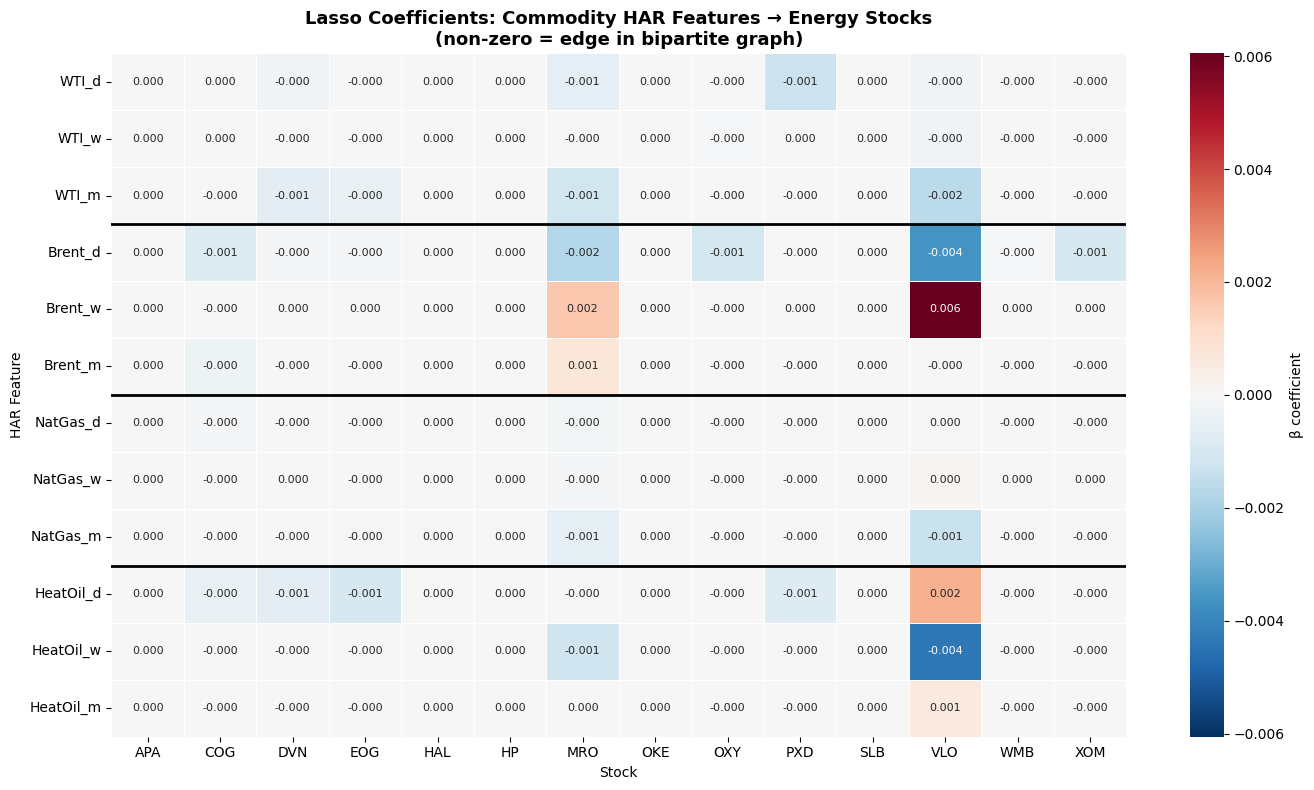

Sparsity: 36/168 non-zero (21.4%)


In [9]:
fig, ax = plt.subplots(figsize=(14, 8))

# Heatmap with diverging colormap
vmax = np.abs(beta_matrix.values).max()
sns.heatmap(beta_matrix, cmap='RdBu_r', center=0, vmin=-vmax, vmax=vmax,
            annot=True, fmt='.3f', ax=ax, annot_kws={'size': 8},
            linewidths=0.5, cbar_kws={'label': 'β coefficient'})

# Group separators for commodities
for y in [3, 6, 9]:
    ax.axhline(y, color='black', linewidth=2)

ax.set_title('Lasso Coefficients: Commodity HAR Features → Energy Stocks\n(non-zero = edge in bipartite graph)',
             fontsize=13, fontweight='bold')
ax.set_ylabel('HAR Feature')
ax.set_xlabel('Stock')

plt.tight_layout()
plt.show()

# Sparsity stats
total_params = beta_matrix.size
nonzero_params = (beta_matrix != 0).sum().sum()
print(f"Sparsity: {nonzero_params}/{total_params} non-zero ({100*nonzero_params/total_params:.1f}%)")

## 4. Build & Visualize the Bipartite Graph

In [10]:
def build_bipartite_graph(beta_matrix, threshold=0.0):
    """
    Build a bipartite graph from the beta matrix.
    
    Nodes:
      - Commodity nodes (left): WTI, Brent, NatGas, HeatOil
      - Stock nodes (right): 14 energy stocks
    
    Edges:
      - Draw edge from commodity c to stock s if any of the 3 horizon betas are non-zero
      - Edge weight = sum of absolute betas for that commodity-stock pair
      - Edge attributes store which horizon(s) are active
    """
    G = nx.DiGraph()
    
    # Add commodity nodes
    commodities = ['WTI', 'Brent', 'NatGas', 'HeatOil']
    for c in commodities:
        G.add_node(c, bipartite=0, node_type='commodity')
    
    # Add stock nodes
    stocks = beta_matrix.columns.tolist()
    for s in stocks:
        G.add_node(s, bipartite=1, node_type='stock')
    
    # Add edges based on non-zero betas
    horizons = ['d', 'w', 'm']
    horizon_names = {'d': 'daily', 'w': 'weekly', 'm': 'monthly'}
    
    for commodity in commodities:
        for stock in stocks:
            # Get the 3 betas for this commodity-stock pair
            beta_d = beta_matrix.loc[f'{commodity}_d', stock]
            beta_w = beta_matrix.loc[f'{commodity}_w', stock]
            beta_m = beta_matrix.loc[f'{commodity}_m', stock]
            
            betas = {'d': beta_d, 'w': beta_w, 'm': beta_m}
            active = {h: b for h, b in betas.items() if abs(b) > threshold}
            
            if active:
                weight = sum(abs(b) for b in active.values())
                dominant = max(active.keys(), key=lambda h: abs(active[h]))
                G.add_edge(commodity, stock, 
                          weight=weight,
                          betas=betas,
                          active_horizons=list(active.keys()),
                          dominant_horizon=dominant)
    
    return G

G = build_bipartite_graph(beta_matrix)
print(f"Bipartite graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"  Commodity nodes: {[n for n, d in G.nodes(data=True) if d.get('node_type') == 'commodity']}")
print(f"  Stock nodes: {[n for n, d in G.nodes(data=True) if d.get('node_type') == 'stock']}")

Bipartite graph: 18 nodes, 23 edges
  Commodity nodes: ['WTI', 'Brent', 'NatGas', 'HeatOil']
  Stock nodes: ['APA', 'COG', 'DVN', 'EOG', 'HAL', 'HP', 'MRO', 'OKE', 'OXY', 'PXD', 'SLB', 'VLO', 'WMB', 'XOM']


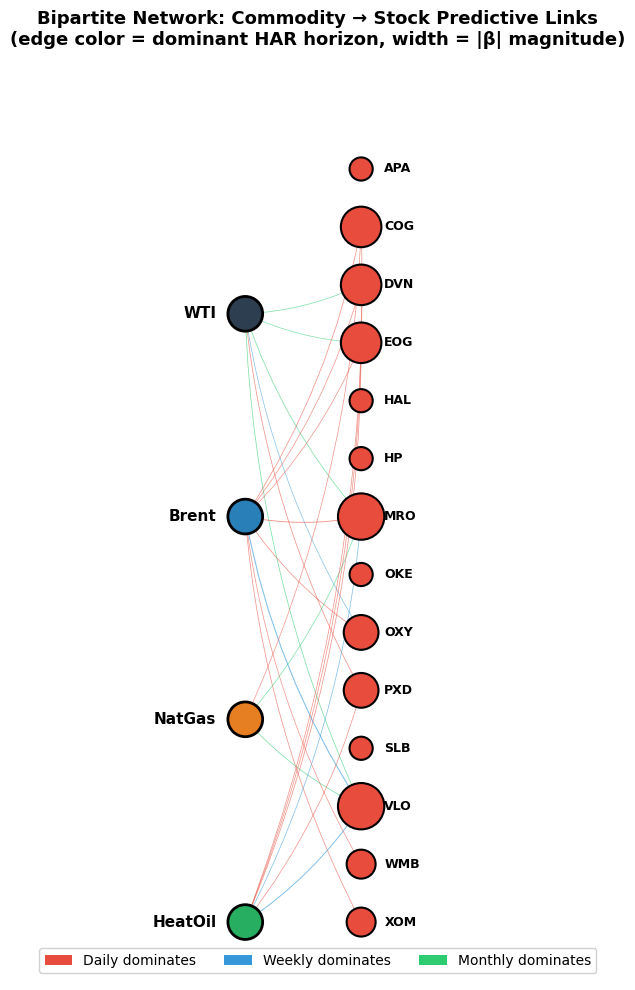

In [11]:
def visualize_bipartite_graph(G, figsize=(16, 10)):
    """Visualize the bipartite commodity → stock graph."""
    fig, ax = plt.subplots(figsize=figsize)
    
    # Separate node types
    commodities = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'commodity']
    stocks = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'stock']
    
    # Position nodes: commodities on left, stocks on right
    pos = {}
    for i, c in enumerate(commodities):
        pos[c] = (0, len(commodities) - 1 - i)
    for i, s in enumerate(stocks):
        pos[s] = (2, len(stocks) - 1 - i)
    
    # Normalize positions
    max_y = max(len(commodities), len(stocks))
    for node in pos:
        x, y = pos[node]
        pos[node] = (x, y * max_y / (len(stocks) if x == 2 else len(commodities)))
    
    # Colors for horizons
    horizon_colors = {'d': '#E74C3C', 'w': '#3498DB', 'm': '#2ECC71'}
    
    # Draw edges
    for u, v, data in G.edges(data=True):
        color = horizon_colors.get(data.get('dominant_horizon', 'd'), 'gray')
        weight = data.get('weight', 0.1)
        width = 0.5 + weight * 30  # Scale for visibility
        ax.annotate('', xy=pos[v], xytext=pos[u],
                   arrowprops=dict(arrowstyle='->', color=color, lw=width, alpha=0.6,
                                  connectionstyle='arc3,rad=0.1'))
    
    # Draw commodity nodes
    comm_colors = {'WTI': '#2C3E50', 'Brent': '#2980B9', 'NatGas': '#E67E22', 'HeatOil': '#27AE60'}
    for c in commodities:
        x, y = pos[c]
        circle = plt.Circle((x, y), 0.3, color=comm_colors.get(c, 'gray'), ec='black', lw=2, zorder=5)
        ax.add_patch(circle)
        ax.text(x - 0.5, y, c, ha='right', va='center', fontsize=11, fontweight='bold')
    
    # Draw stock nodes
    for s in stocks:
        x, y = pos[s]
        out_degree = G.in_degree(s)  # edges coming into this stock
        size = 0.2 + out_degree * 0.05
        circle = plt.Circle((x, y), size, color='#E74C3C', ec='black', lw=1.5, zorder=5)
        ax.add_patch(circle)
        ax.text(x + 0.4, y, s, ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#E74C3C', label='Daily dominates'),
        Patch(facecolor='#3498DB', label='Weekly dominates'),
        Patch(facecolor='#2ECC71', label='Monthly dominates'),
    ]
    ax.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=10, framealpha=0.9)
    
    ax.set_xlim(-1, 3.5)
    ax.set_ylim(-1, max_y + 1)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Bipartite Network: Commodity → Stock Predictive Links\n(edge color = dominant HAR horizon, width = |β| magnitude)',
                fontsize=13, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

visualize_bipartite_graph(G)

## 5. Network Statistics & Insights

In [12]:
# Degree analysis: which commodities predict the most stocks?
commodities = ['WTI', 'Brent', 'NatGas', 'HeatOil']
stocks = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'stock']

print("COMMODITY OUT-DEGREE (# stocks each commodity predicts):")
for c in commodities:
    out_deg = G.out_degree(c)
    print(f"  {c}: {out_deg} stocks")

print("\nSTOCK IN-DEGREE (# commodities predicting each stock):")
stock_degrees = [(s, G.in_degree(s)) for s in stocks]
stock_degrees.sort(key=lambda x: x[1], reverse=True)
for s, deg in stock_degrees:
    print(f"  {s}: {deg} commodities")

COMMODITY OUT-DEGREE (# stocks each commodity predicts):
  WTI: 6 stocks
  Brent: 8 stocks
  NatGas: 3 stocks
  HeatOil: 6 stocks

STOCK IN-DEGREE (# commodities predicting each stock):
  MRO: 4 commodities
  VLO: 4 commodities
  COG: 3 commodities
  DVN: 3 commodities
  EOG: 3 commodities
  OXY: 2 commodities
  PXD: 2 commodities
  WMB: 1 commodities
  XOM: 1 commodities
  APA: 0 commodities
  HAL: 0 commodities
  HP: 0 commodities
  OKE: 0 commodities
  SLB: 0 commodities


In [13]:
# Which horizon dominates across all edges?
horizon_counts = {'d': 0, 'w': 0, 'm': 0}
for u, v, data in G.edges(data=True):
    for h in data.get('active_horizons', []):
        horizon_counts[h] += 1

print("ACTIVE HORIZON COUNTS (across all edges):")
print(f"  Daily:   {horizon_counts['d']}")
print(f"  Weekly:  {horizon_counts['w']}")
print(f"  Monthly: {horizon_counts['m']}")

# Dominant horizon distribution
dominant_counts = {'d': 0, 'w': 0, 'm': 0}
for u, v, data in G.edges(data=True):
    dom = data.get('dominant_horizon')
    if dom:
        dominant_counts[dom] += 1

print("\nDOMINANT HORIZON (per edge):")
print(f"  Daily:   {dominant_counts['d']}")
print(f"  Weekly:  {dominant_counts['w']}")
print(f"  Monthly: {dominant_counts['m']}")

ACTIVE HORIZON COUNTS (across all edges):
  Daily:   19
  Weekly:  8
  Monthly: 9

DOMINANT HORIZON (per edge):
  Daily:   13
  Weekly:  4
  Monthly: 6


In [14]:
# Top 10 strongest edges
edges_list = []
for u, v, data in G.edges(data=True):
    edges_list.append({
        'commodity': u,
        'stock': v,
        'weight': data['weight'],
        'dominant': data['dominant_horizon'],
        'beta_d': data['betas']['d'],
        'beta_w': data['betas']['w'],
        'beta_m': data['betas']['m'],
    })

edges_df = pd.DataFrame(edges_list).sort_values('weight', ascending=False)
print("TOP 10 STRONGEST EDGES (by |β| weight):")
edges_df.head(10)

TOP 10 STRONGEST EDGES (by |β| weight):


,commodity,stock,weight,dominant,beta_d,beta_w,beta_m
11,Brent,VLO,0.009663,w,-0.003612,0.006052,-0.000000
22,HeatOil,VLO,0.007065,w,0.002135,-0.004361,0.000569
9,Brent,MRO,0.004123,d,-0.001750,0.001640,0.000733
5,WTI,VLO,0.002120,m,-0.000206,-0.000281,-0.001634
2,WTI,MRO,0.001749,m,-0.000593,-0.000000,-0.001155
16,NatGas,VLO,0.001458,m,0.000000,0.000102,-0.001356
4,WTI,PXD,0.001315,d,-0.001315,0.000000,-0.000000
20,HeatOil,MRO,0.001207,w,-0.000000,-0.001207,0.000000
6,Brent,COG,0.001137,d,-0.000842,-0.000000,-0.000295
10,Brent,OXY,0.001076,d,-0.001076,-0.000000,-0.000000


## 6. Feature Importance Aggregated

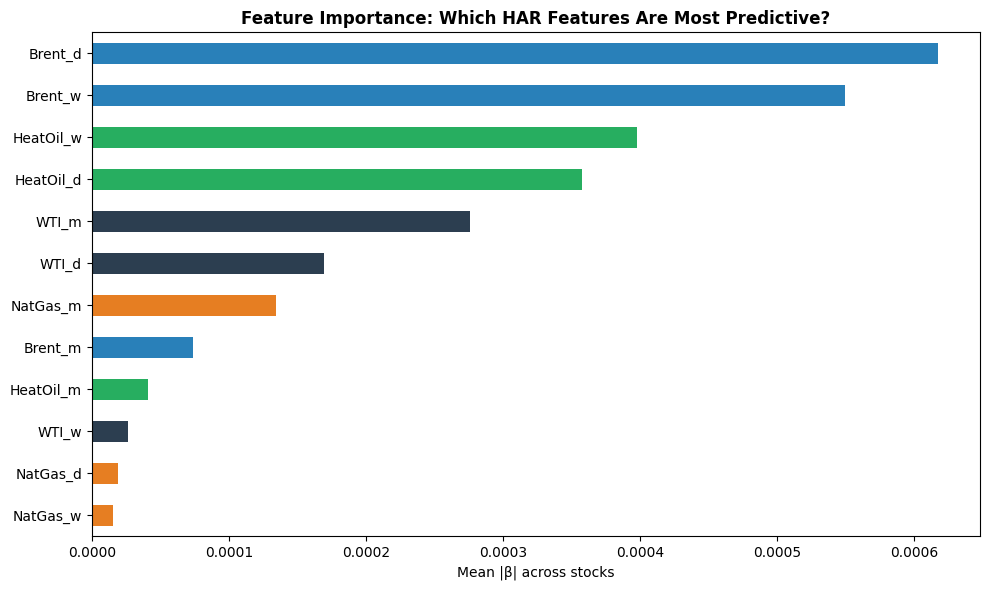

Brent_d      0.000617
Brent_w      0.000549
HeatOil_w    0.000398
HeatOil_d    0.000357
WTI_m        0.000276
WTI_d        0.000170
NatGas_m     0.000134
Brent_m      0.000073
HeatOil_m    0.000041
WTI_w        0.000026
NatGas_d     0.000019
NatGas_w     0.000015


In [15]:
# Average absolute beta per feature (across all stocks)
feature_importance = beta_matrix.abs().mean(axis=1).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2C3E50' if 'WTI' in f else '#2980B9' if 'Brent' in f else '#E67E22' if 'NatGas' in f else '#27AE60'
          for f in feature_importance.index]
feature_importance.plot.barh(ax=ax, color=colors)
ax.set_xlabel('Mean |β| across stocks')
ax.set_title('Feature Importance: Which HAR Features Are Most Predictive?', fontsize=12, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print(feature_importance.to_string())

## 7. Compute Residuals (for Strategy)

In [16]:
# Compute predictions and residuals for each stock
predictions = pd.DataFrame(index=X.index, columns=Y.columns)
residuals = pd.DataFrame(index=X.index, columns=Y.columns)

for stock in Y.columns:
    model = results[stock]
    y_pred = model.predict(X_scaled.values)
    predictions[stock] = y_pred
    residuals[stock] = Y[stock].values - y_pred

print(f"Predictions shape: {predictions.shape}")
print(f"Residuals shape: {residuals.shape}")

Predictions shape: (3261, 14)
Residuals shape: (3261, 14)


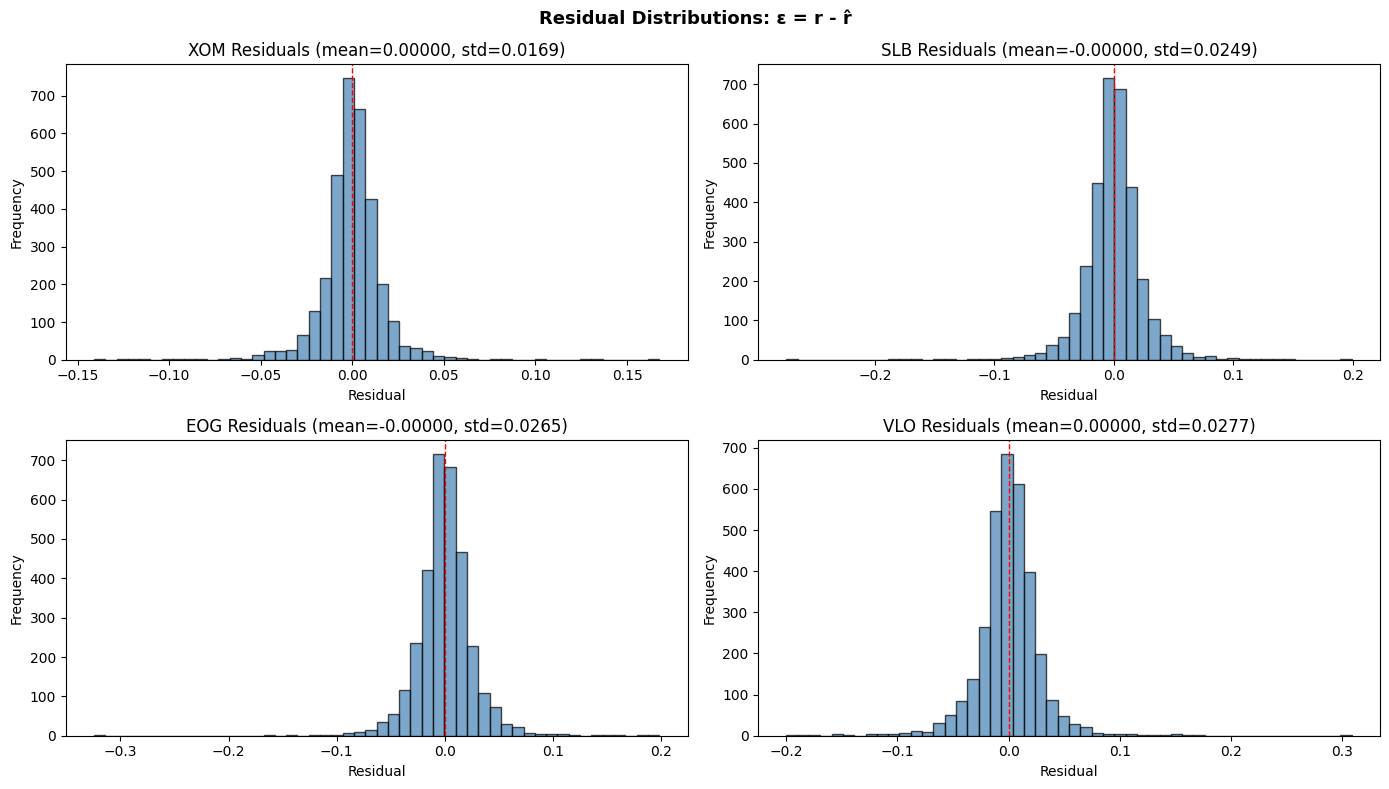

In [17]:
# Residual distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Sample 4 stocks
sample_stocks = ['XOM', 'SLB', 'EOG', 'VLO']
for ax, stock in zip(axes.flat, sample_stocks):
    res = residuals[stock].dropna()
    ax.hist(res, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=1)
    ax.set_title(f'{stock} Residuals (mean={res.mean():.5f}, std={res.std():.4f})')
    ax.set_xlabel('Residual')
    ax.set_ylabel('Frequency')

plt.suptitle('Residual Distributions: ε = r - r̂', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

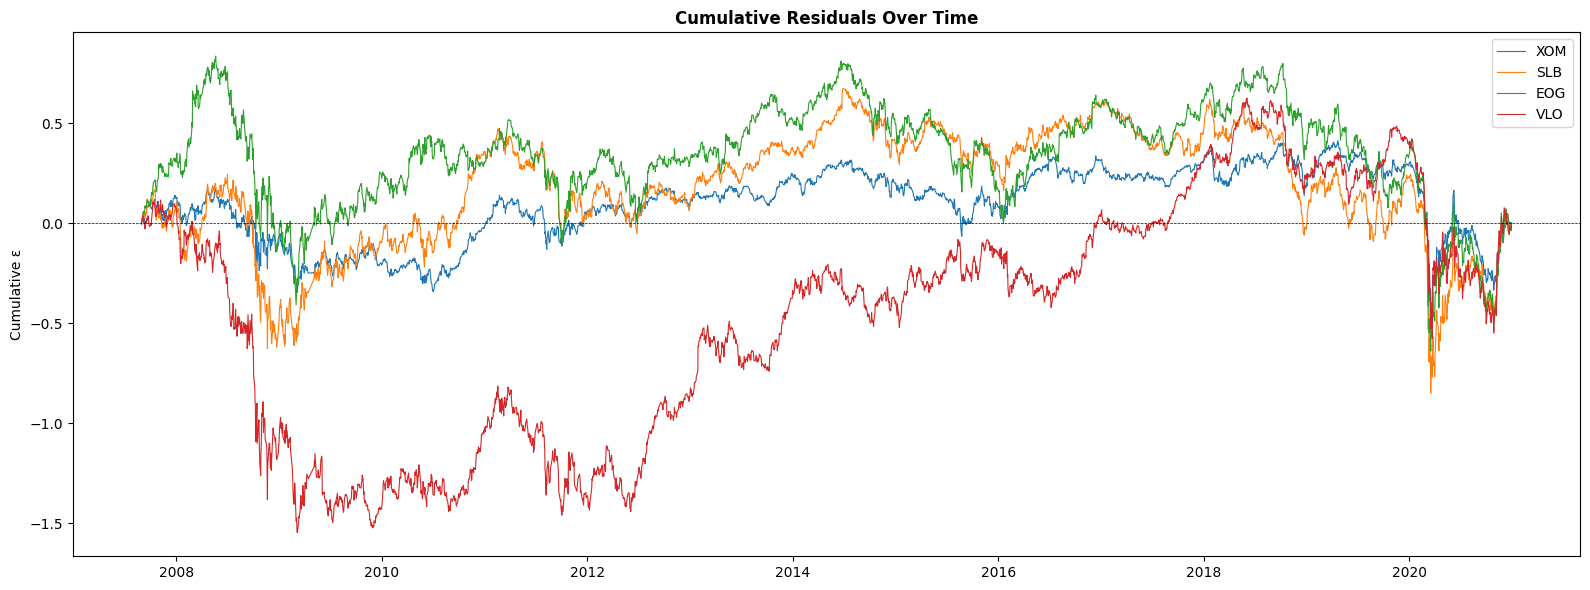

In [18]:
# Cumulative residuals over time (should be mean-zero if model is unbiased)
fig, ax = plt.subplots(figsize=(16, 6))

for stock in sample_stocks:
    cum_res = residuals[stock].dropna().cumsum()
    ax.plot(cum_res, label=stock, linewidth=0.8)

ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.set_title('Cumulative Residuals Over Time', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative ε')
ax.legend()
plt.tight_layout()
plt.show()

## 8. Summary

In [19]:
print("=" * 60)
print("HAR-LASSO BIPARTITE NETWORK SUMMARY")
print("=" * 60)
print(f"\nData:")
print(f"  Trading days: {len(common_dates)}")
print(f"  Stocks: {len(stocks)}")
print(f"  Commodities: {len(commodities)}")
print(f"  HAR features: {X.shape[1]} (4 commodities × 3 horizons)")

print(f"\nLasso Results:")
print(f"  Total parameters: {beta_matrix.size}")
print(f"  Non-zero: {(beta_matrix != 0).sum().sum()} ({100*(beta_matrix != 0).sum().sum()/beta_matrix.size:.1f}%)")
print(f"  Avg R² across stocks: {np.mean([results[s].score(X_scaled.values[~np.isnan(Y[s].values)], Y[s].values[~np.isnan(Y[s].values)]) for s in Y.columns]):.4f}")

print(f"\nBipartite Graph:")
print(f"  Nodes: {G.number_of_nodes()} ({len(commodities)} commodities + {len(stocks)} stocks)")
print(f"  Edges: {G.number_of_edges()} predictive links")
print(f"  Density: {G.number_of_edges() / (len(commodities) * len(stocks)):.2%}")

print(f"\nDominant Horizon: {max(dominant_counts.keys(), key=lambda k: dominant_counts[k])}")
print(f"  Daily: {dominant_counts['d']}, Weekly: {dominant_counts['w']}, Monthly: {dominant_counts['m']}")
print("=" * 60)

HAR-LASSO BIPARTITE NETWORK SUMMARY

Data:
  Trading days: 3261
  Stocks: 14
  Commodities: 4
  HAR features: 12 (4 commodities × 3 horizons)

Lasso Results:
  Total parameters: 168
  Non-zero: 36 (21.4%)
  Avg R² across stocks: 0.0042

Bipartite Graph:
  Nodes: 18 (4 commodities + 14 stocks)
  Edges: 23 predictive links
  Density: 41.07%

Dominant Horizon: d
  Daily: 13, Weekly: 4, Monthly: 6
